# Regression

_Author: Christoph Rahmede_

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

plt.style.use('ggplot')
sns.set(font_scale=1.5)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

warnings.simplefilter('ignore')
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import norm
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV, Ridge

## Load the data

In [3]:
df = pd.read_csv('../../../dataset-collection/auto-mpg/auto-mpg.csv',
                 sep='\s+', header=None)
df.columns = ['mpg', 'cylinders', 'displacement', 'horsepower',
              'weight', 'acceleration', 'year', 'origin', 'name']
df.drop(df[df.horsepower == '?'].index, inplace=True)
df['horsepower'] = df.horsepower.astype(float)
df['brand'] = df.name.map(lambda x: x.split(' ')[0]
                          ).replace(
    {'toyouta': 'toyota',
     'maxda': 'mazda',
     'chevroelt': 'chevrolet',
     'vw': 'volkswagen',
     'vokswagen': 'volkswagen',
     'mercedes-benz': 'mercedes'})
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 397
Data columns (total 10 columns):
mpg             392 non-null float64
cylinders       392 non-null int64
displacement    392 non-null float64
horsepower      392 non-null float64
weight          392 non-null float64
acceleration    392 non-null float64
year            392 non-null int64
origin          392 non-null int64
name            392 non-null object
brand           392 non-null object
dtypes: float64(5), int64(3), object(2)
memory usage: 33.7+ KB


In [4]:
X = df.copy()
y = X.pop('mpg')
X.drop(['brand', 'name'], axis=1, inplace=True)
X = pd.get_dummies(X, columns=['origin'], drop_first=True)
X.head()

,cylinders,displacement,horsepower,weight,acceleration,year,origin_2,origin_3
0,8,307.0,130.0,3504.0,12.0,70,0,0
1,8,350.0,165.0,3693.0,11.5,70,0,0
2,8,318.0,150.0,3436.0,11.0,70,0,0
3,8,304.0,150.0,3433.0,12.0,70,0,0
4,8,302.0,140.0,3449.0,10.5,70,0,0


In [5]:
poly = PolynomialFeatures(degree=2)
X_p = poly.fit_transform(X)
X_p[:2,:]

array([[1.0000000e+00, 8.0000000e+00, 3.0700000e+02, 1.3000000e+02,
        3.5040000e+03, 1.2000000e+01, 7.0000000e+01, 0.0000000e+00,
        0.0000000e+00, 6.4000000e+01, 2.4560000e+03, 1.0400000e+03,
        2.8032000e+04, 9.6000000e+01, 5.6000000e+02, 0.0000000e+00,
        0.0000000e+00, 9.4249000e+04, 3.9910000e+04, 1.0757280e+06,
        3.6840000e+03, 2.1490000e+04, 0.0000000e+00, 0.0000000e+00,
        1.6900000e+04, 4.5552000e+05, 1.5600000e+03, 9.1000000e+03,
        0.0000000e+00, 0.0000000e+00, 1.2278016e+07, 4.2048000e+04,
        2.4528000e+05, 0.0000000e+00, 0.0000000e+00, 1.4400000e+02,
        8.4000000e+02, 0.0000000e+00, 0.0000000e+00, 4.9000000e+03,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00],
       [1.0000000e+00, 8.0000000e+00, 3.5000000e+02, 1.6500000e+02,
        3.6930000e+03, 1.1500000e+01, 7.0000000e+01, 0.0000000e+00,
        0.0000000e+00, 6.4000000e+01, 2.8000000e+03, 1.3200000e+03,
        2.9544000e+04, 9

In [23]:
poly.get_feature_names()

['1',
 'x0',
 'x1',
 'x2',
 'x3',
 'x4',
 'x5',
 'x6',
 'x7',
 'x0^2',
 'x0 x1',
 'x0 x2',
 'x0 x3',
 'x0 x4',
 'x0 x5',
 'x0 x6',
 'x0 x7',
 'x1^2',
 'x1 x2',
 'x1 x3',
 'x1 x4',
 'x1 x5',
 'x1 x6',
 'x1 x7',
 'x2^2',
 'x2 x3',
 'x2 x4',
 'x2 x5',
 'x2 x6',
 'x2 x7',
 'x3^2',
 'x3 x4',
 'x3 x5',
 'x3 x6',
 'x3 x7',
 'x4^2',
 'x4 x5',
 'x4 x6',
 'x4 x7',
 'x5^2',
 'x5 x6',
 'x5 x7',
 'x6^2',
 'x6 x7',
 'x7^2']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X_p, y, test_size=0.2, random_state=1)

Whereas ordinary least squares regression will lead to the same predictions with or without standard scaling, as soon as we add regularization it is mandatory.

In [7]:
# standardize the data
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_test = pd.DataFrame(scaler.transform(X_test))

In [8]:
from sklearn.linear_model import Ridge

In [9]:
# create a linear regression model instance
alphas = np.logspace(-1,1,30)
model = RidgeCV(alphas=alphas,cv=5)

# get cross validated scores
scores = cross_val_score(model, X_train, y_train, cv=5)
score_dict = {}
for alpha in alphas:
    score_dict[alpha] = cross_val_score(Ridge(alpha=alpha), X_train, y_train, cv=5).mean()
print("Cross-validated training scores:", scores)
print("Mean cross-validated training score:", scores.mean())
# fit and evaluate the data on the whole training set
res = model.fit(X_train, y_train)
print("Training Score:", model.score(X_train, y_train))
# evaluate the data on the test set
print("Test Score:", model.score(X_test, y_test))

baseline_train = mean_squared_error(y_train, [y_train.mean()]*len(X_train))
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)

Cross-validated training scores: [0.8710306  0.82371328 0.85034663 0.87658159 0.86919821]
Mean cross-validated training score: 0.8581740651328718
Training Score: 0.8944120312279044
Test Score: 0.8671823772450328


In [10]:
# collect the model coefficients in a dataframe
df_coef = pd.DataFrame(model.coef_, index=X_train.columns,
                       columns=['coefficients'])
# calculate the absolute values of the coefficients
df_coef['coef_abs'] = df_coef.coefficients.abs()
df_coef

,coefficients,coef_abs
0,0.000000,0.000000
1,-0.788495,0.788495
2,-1.570488,1.570488
3,0.955049,0.955049
4,-1.908641,1.908641
5,-4.026976,4.026976
6,-0.437904,0.437904
7,-1.780354,1.780354
8,-1.185976,1.185976
9,-0.636012,0.636012


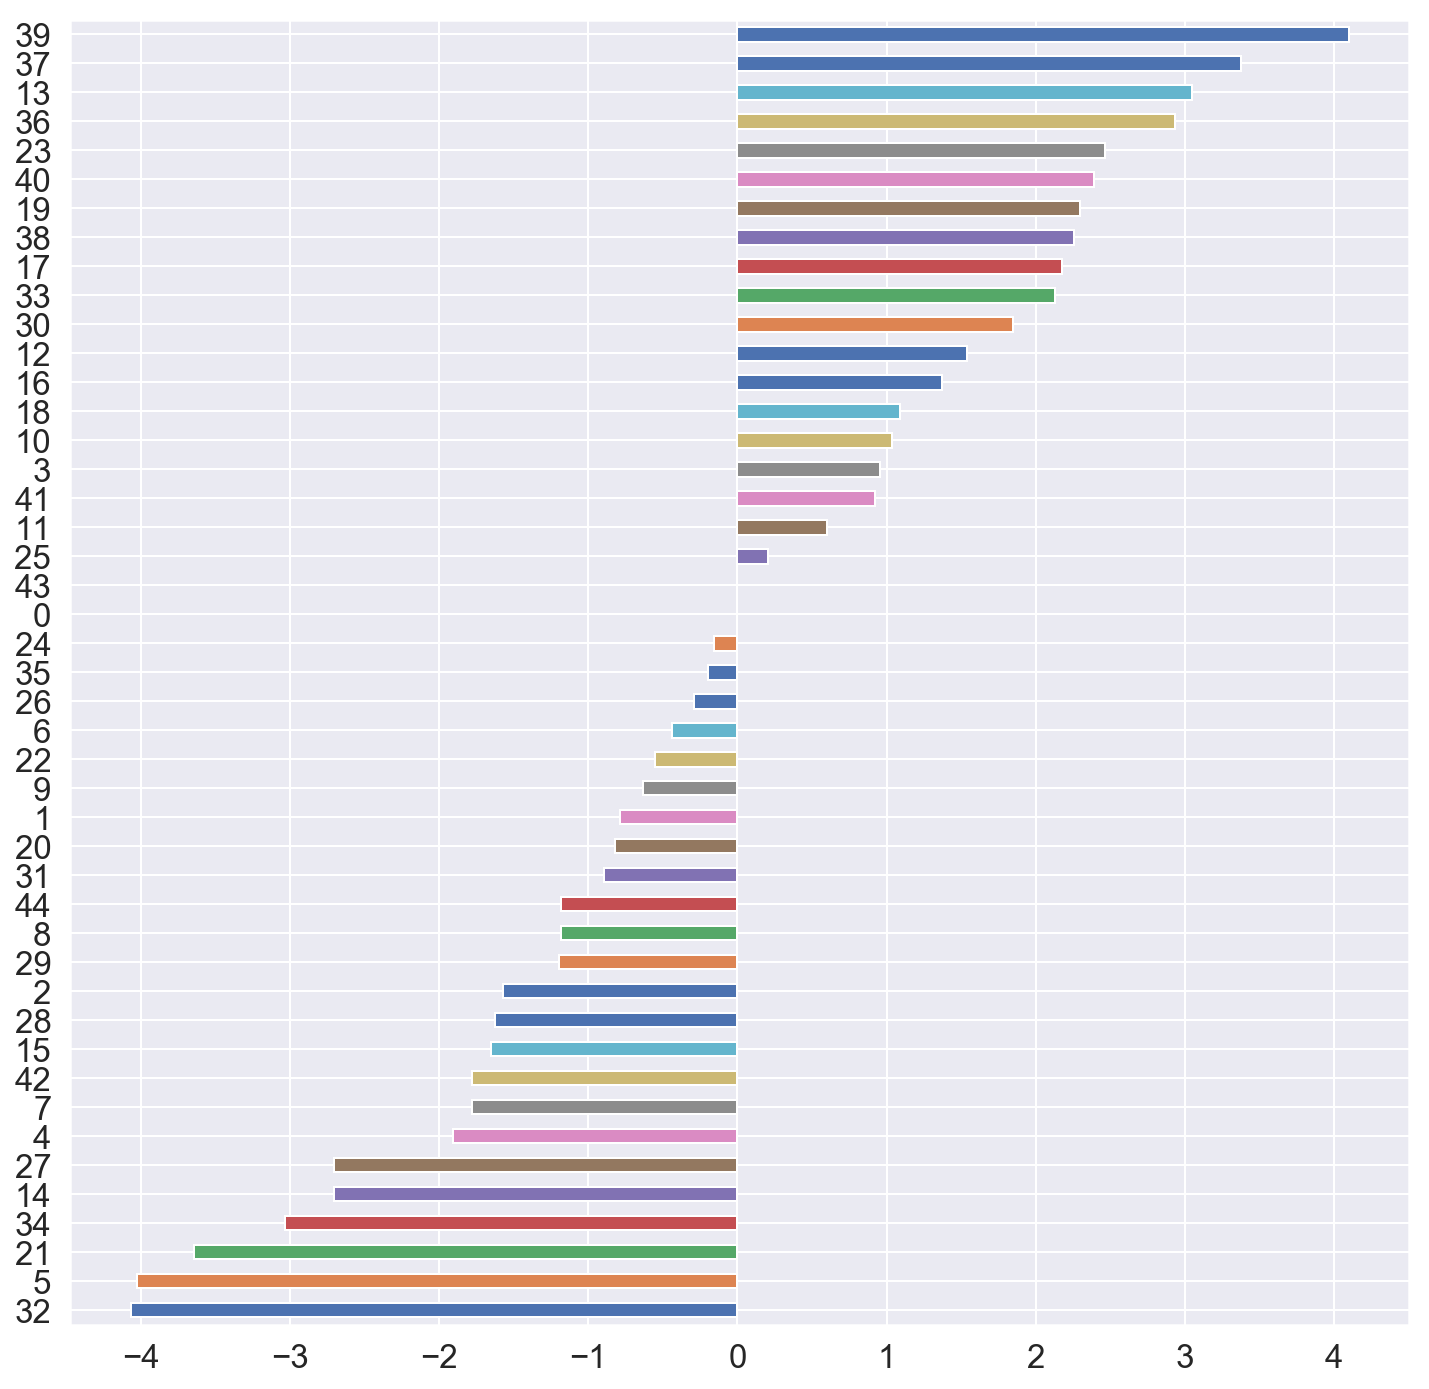

In [11]:
# plot the magnitude of the coefficients
df_coef['coefficients'].sort_values().plot(kind='barh', figsize=(12,12))
plt.show()

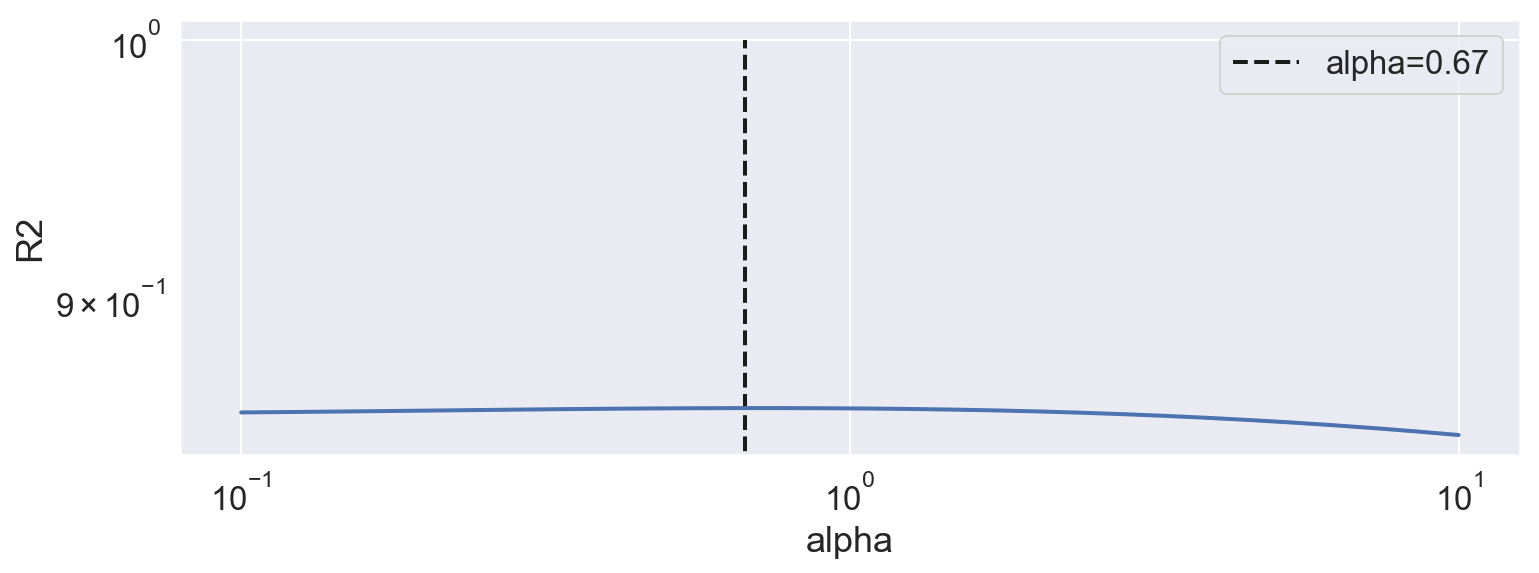

In [12]:
fig, ax = plt.subplots( figsize=(12, 4))
ax.plot(list(score_dict.keys()), list(score_dict.values()), lw=2)
ax.vlines(model.alpha_, 0, 1, lw=2, linestyle='--',
             label='alpha={:.2}'.format(model.alpha_))
ax.set_xlabel('alpha')
ax.set_ylabel('R2')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc='upper right')
plt.show()

In [14]:
training_sizes, train_scores, test_scores = skplt.estimators.learning_curve(
    model, X_train, y_train, cv=5, scoring='r2')

In [15]:
training_sizes

array([ 25,  81, 137, 193, 250])

In [16]:
train_scores

array([[0.92854764, 0.97965107, 0.97965107, 0.97965107, 0.97965107],
       [0.88758765, 0.9097867 , 0.91847153, 0.91847153, 0.91847153],
       [0.8908862 , 0.90458513, 0.90635136, 0.89273095, 0.89273095],
       [0.86976474, 0.89908018, 0.90252466, 0.90224171, 0.90112528],
       [0.89439004, 0.89267267, 0.89711651, 0.8927242 , 0.89850515]])

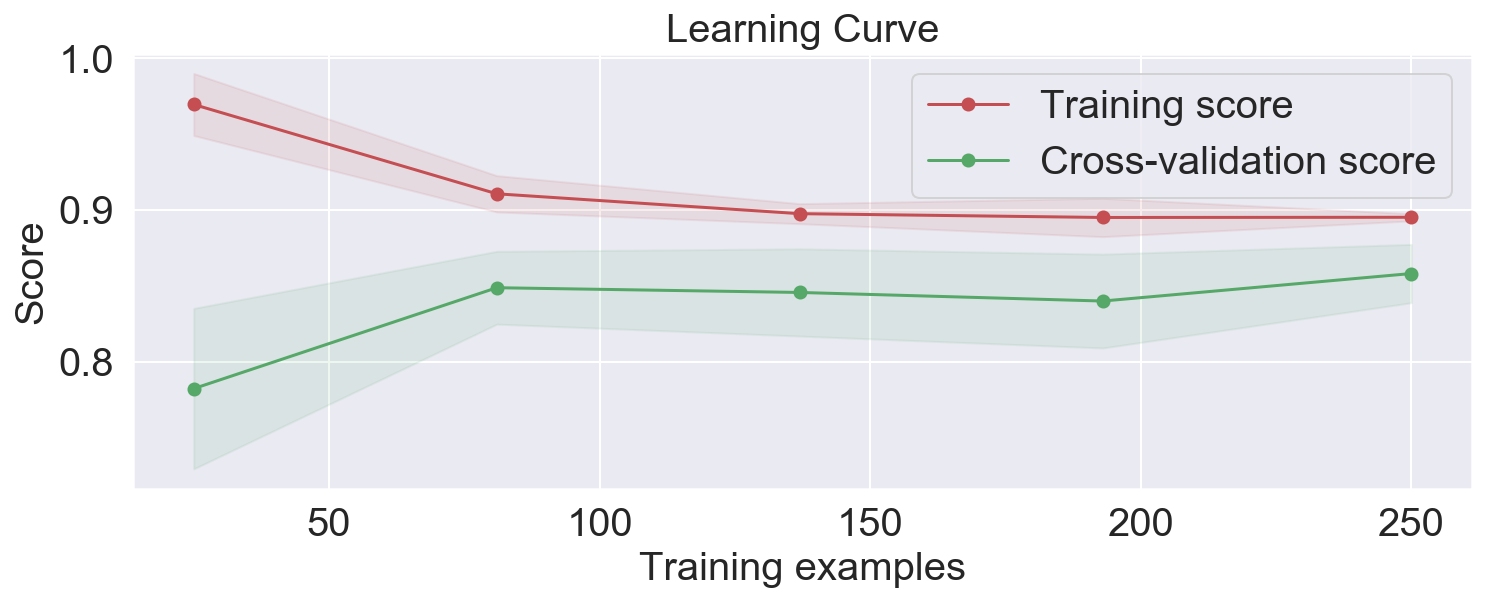

In [17]:
fig, ax = plt.subplots(figsize=(12, 4))
skplt.estimators.plot_learning_curve(model, X_train, y_train, cv=5, 
    scoring='r2', title_fontsize=20, text_fontsize=20, ax=ax)
ax.grid()

[0.88764052] 2.6296785525107467


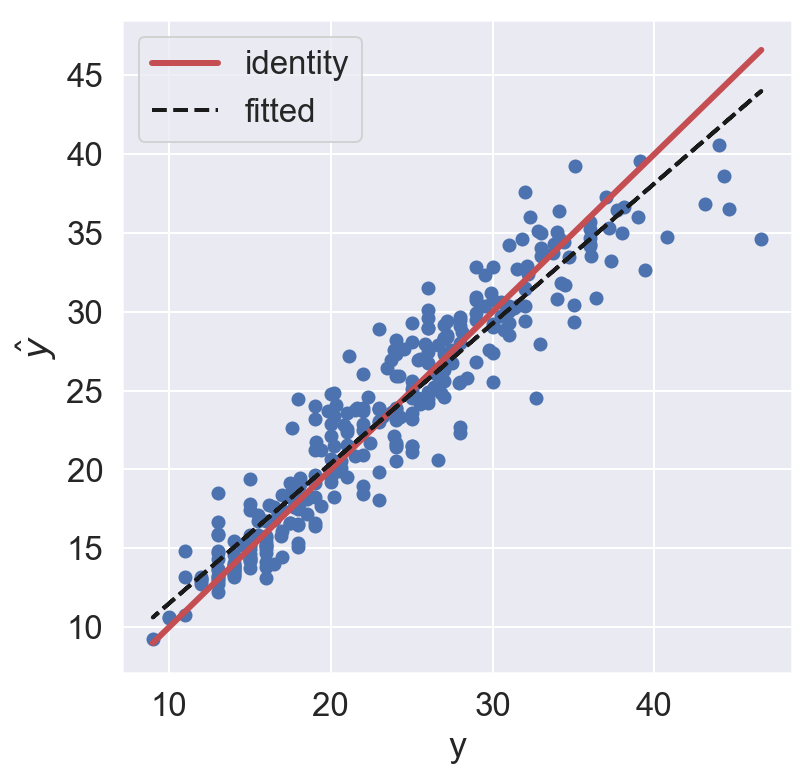

In [18]:
model_y = LinearRegression()
model_y.fit(y_train.values.reshape(-1, 1), predictions_train)
print(model_y.coef_, model_y.intercept_)

plt.figure(figsize=(6, 6))
plt.scatter(y_train, predictions_train)
plt.plot([y_train.min(), y_train.max()], [y_train.min(),y_train.max()], 
         lw=3, color='r', label='identity')
plt.plot(y_train, model_y.predict(y_train.values.reshape(-1, 1)),
         lw=2, linestyle='--', color='k', label='fitted')
plt.xlabel('y')
plt.ylabel('$\hat{y}$')
plt.legend()
plt.show()

We can compare the residuals for the training and test sets.

In [19]:
residuals_train = y_train-predictions_train
residuals_test = y_test-predictions_test

In [20]:
import statsmodels.api as sm

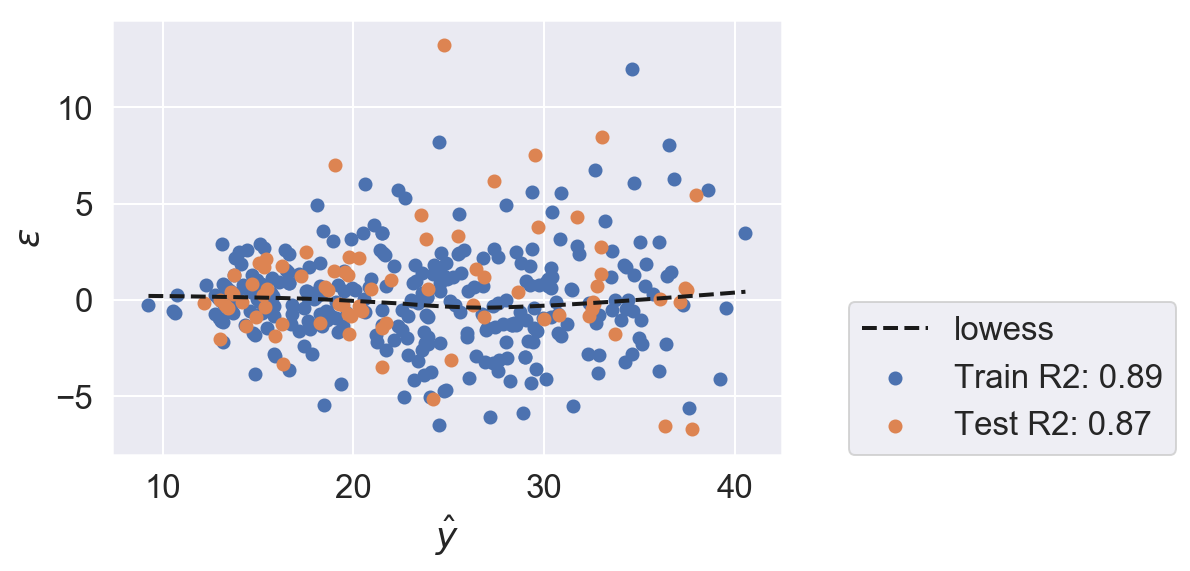

In [21]:
lowess_fit = sm.nonparametric.lowess(residuals_train,predictions_train)
plt.plot(lowess_fit[:, 0], lowess_fit[:, 1], color='k', ls='--', lw=2, label='lowess')
plt.scatter(predictions_train, residuals_train,
            label='Train R2: {:.2f}'.format(model.score(X_train, y_train)))
plt.scatter(predictions_test, residuals_test,
            label='Test R2: {:.2f}'.format(model.score(X_test, y_test)))
plt.xlabel('$\hat{y}$')
plt.ylabel('$\epsilon$')
plt.legend(loc=[1.1, 0])
plt.show()

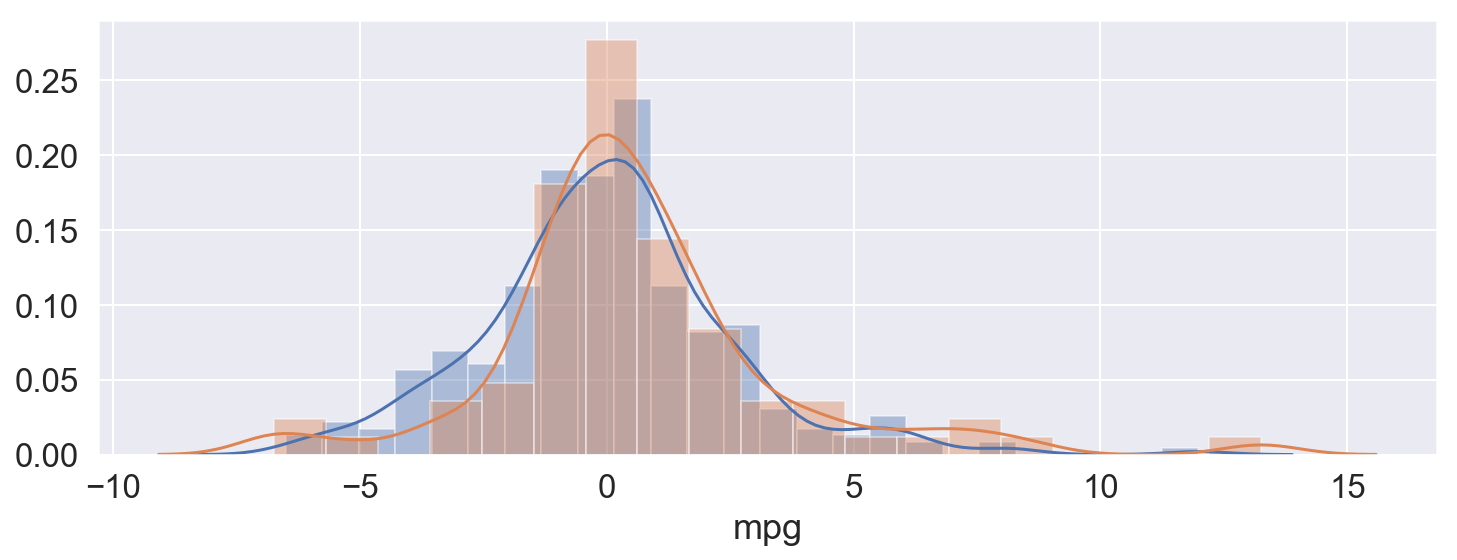

In [22]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.distplot(residuals_train, ax=ax)
sns.distplot(residuals_test, ax=ax)
plt.show()